In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
from numba import njit, prange
import matplotlib.pyplot as plt


In [2]:
# Функция для вычисления скользящей корреляции с помощью NumPy
@njit(parallel=True)
def rolling_correlation(prices1, prices2, window_size):
    length = len(prices1) - window_size + 1
    corrs = np.empty(length)
    
    for i in prange(length):
        window1 = prices1[i:i+window_size]
        window2 = prices2[i:i+window_size]
        
        mean1 = np.mean(window1)
        mean2 = np.mean(window2)
        
        std1 = np.std(window1)
        std2 = np.std(window2)
        
        if std1 == 0 or std2 == 0:
            corrs[i] = np.nan
        else:
            cov = np.mean((window1 - mean1) * (window2 - mean2))
            corr = cov / (std1 * std2)
            corrs[i] = corr
            
    return corrs

# Функция для преобразования коэффициента корреляции Пирсона
@njit
def transform_correlation(x):
    term = (2 * x * np.sqrt(1 - x**2) - 1) / (2 * x**2 - 1)
    if x + np.sqrt(1 - x**2) >= 0:
        return 0.5 - (np.arctan(term) / (np.pi / 2))
    else:
        return -(0.5 - (np.arctan((-2 * x * np.sqrt(1 - x**2) - 1) / (2 * x**2 - 1)) / (np.pi / 2)))


In [3]:
# Открываем файл и считываем данные в DataFrame
file_path = 'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\closing_prices_Foreign_new_2022-2024.xlsx' #'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\SP500_closing_prices.xlsx' #'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\closing_prices_MOEX_2022_2024.xlsx'
data = pd.read_excel(file_path)

# Создаем словарь для хранения данных по акциям
stock_prices = {}

# Перебираем столбцы, начиная со второго (первый столбец — это Дата)
for stock in data.columns[0:]:
    stock_prices[stock] = np.array(data[stock].tolist())

# Количество наблюдений для окна (например, 50)
window_size = 200

# Получаем все пары акций
stocks = list(stock_prices.keys())
n_stocks = len(stocks)

# Создаем словарь для хранения массивов коэффициентов корреляции
correlation_results = {}


# Вычисляем скользящую корреляцию для каждой пары акций
for i in prange(n_stocks):
    print(i)
    for j in prange(i + 1, n_stocks):
        stock1 = stocks[i]
        stock2 = stocks[j]

        # Берем полные ряды данных по каждой акции
        prices1 = stock_prices[stock1]
        prices2 = stock_prices[stock2]

        # Вычисляем массив коэффициентов корреляции Пирсона
        if len(prices1) >= window_size and len(prices2) >= window_size:
            corrs = rolling_correlation(prices1, prices2, window_size)
            correlation_results[(stock1, stock2)] = corrs

quadrant_results = {}
for pair, corrs in correlation_results.items():
    transformed_corrs = [transform_correlation(x) for x in corrs]
    quadrant_results[pair] = transformed_corrs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


In [4]:
data.columns[0:]

Index(['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'NVDA', 'JNJ', 'V', 'UNH',
       'PG',
       ...
       'EVRG', 'EQH', 'NWL', 'PGRE', 'STX', 'STT', 'TPR', 'SEE', 'FANG',
       'SHW'],
      dtype='object', length=181)

In [5]:
data.columns[1:]

Index(['MSFT', 'AMZN', 'GOOGL', 'TSLA', 'NVDA', 'JNJ', 'V', 'UNH', 'PG', 'MA',
       ...
       'EVRG', 'EQH', 'NWL', 'PGRE', 'STX', 'STT', 'TPR', 'SEE', 'FANG',
       'SHW'],
      dtype='object', length=180)

In [6]:
mat = np.zeros((n_stocks, n_stocks))


In [7]:
for i in prange(n_stocks):
    for j in prange(i + 1, n_stocks):
        pair = (stocks[i], stocks[j])
        if pair in quadrant_results:
            last_value = quadrant_results[pair][-1]  # последний элемент массива
            mat[i][j] = last_value
            mat[j][i] = last_value
    mat[i][i] = 1

In [8]:
mat

array([[ 1.        ,  0.30442754,  0.23343883, ...,  0.02868807,
         0.06235674,  0.34893599],
       [ 0.30442754,  1.        ,  0.6115313 , ...,  0.06906997,
         0.33656355,  0.01927529],
       [ 0.23343883,  0.6115313 ,  1.        , ...,  0.01198   ,
         0.48208212,  0.14140637],
       ...,
       [ 0.02868807,  0.06906997,  0.01198   , ...,  1.        ,
        -0.08018333, -0.09737791],
       [ 0.06235674,  0.33656355,  0.48208212, ..., -0.08018333,
         1.        ,  0.03577213],
       [ 0.34893599,  0.01927529,  0.14140637, ..., -0.09737791,
         0.03577213,  1.        ]])

In [9]:
# Открываем файл и считываем данные в DataFrame
file_path = 'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\closing_prices_Foreign_new_2022-2024.xlsx' #'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\SP500_closing_prices.xlsx' #'C:\\Users\\verei\\Documents\\Fin_Econ_Project1\\closing_prices_MOEX_2022_2024.xlsx'

In [10]:
data = pd.read_excel(file_path)

In [11]:
data

,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,JNJ,V,UNH,PG,...,EVRG,EQH,NWL,PGRE,STX,STT,TPR,SEE,FANG,SHW
0,157.960007,284.470001,124.500000,116.583000,300.980011,19.533001,178.639999,211.529999,501.149994,158.380005,...,67.080002,29.000000,22.430000,9.37,82.449997,68.580002,33.599998,64.349998,127.500000,268.779999
1,159.479996,281.779999,124.253502,117.334000,303.083344,19.601999,178.289993,208.559998,499.619995,156.210007,...,67.379997,29.920000,23.410000,9.55,83.889999,69.910004,32.740002,65.570000,136.110001,269.369995
2,166.020004,289.980011,125.928497,122.261002,317.540009,20.334000,180.199997,214.520004,507.619995,157.360001,...,68.730003,31.000000,23.280001,9.71,86.449997,72.760002,33.250000,68.480003,142.490005,282.529999
3,156.770004,277.350006,116.406998,116.505501,291.093323,18.844000,176.759995,205.240005,494.720001,154.460007,...,68.279999,29.610001,22.590000,9.42,82.720001,71.220001,31.480000,64.800003,138.589996,276.950012
4,157.279999,274.730011,114.772499,115.746498,288.549988,18.674999,176.369995,202.820007,499.619995,156.000000,...,68.099998,29.340000,22.480000,9.28,82.620003,70.129997,30.340000,65.599998,142.929993,273.380005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,231.300003,419.140015,187.539993,164.960007,219.160004,138.070007,161.600006,280.679993,605.400024,172.509995,...,59.730000,44.000000,7.470000,5.05,111.059998,90.930000,45.590000,35.480000,190.699997,384.160004
617,233.850006,418.739990,187.690002,165.460007,219.570007,131.600006,164.100006,279.290009,556.289978,173.570007,...,60.340000,44.099998,7.490000,5.22,111.790001,91.820000,45.200001,34.990002,179.770004,388.549988
618,231.779999,416.119995,186.889999,165.160004,221.330002,135.720001,164.279999,287.519989,571.340027,172.380005,...,61.150002,44.570000,7.730000,5.21,111.730003,92.879997,45.459999,35.299999,182.460007,389.390015
619,232.149994,416.720001,187.529999,162.929993,220.889999,136.929993,164.470001,290.390015,566.030029,172.279999,...,60.779999,45.509998,7.680000,5.27,112.449997,92.550003,45.180000,36.669998,183.960007,389.079987


In [12]:
corrMat = data.corr()

corrMat

,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,JNJ,V,UNH,PG,...,EVRG,EQH,NWL,PGRE,STX,STT,TPR,SEE,FANG,SHW
AAPL,1.000000,0.867603,0.812748,0.850863,0.212904,0.861643,-0.506516,0.779493,0.457731,0.765616,...,-0.399801,0.676756,-0.701421,-0.527121,0.733495,0.315567,0.353385,-0.680587,0.624737,0.778795
MSFT,0.867603,1.000000,0.941013,0.946438,-0.054562,0.927613,-0.648444,0.939184,0.234449,0.820052,...,-0.621523,0.744491,-0.784527,-0.597604,0.814664,0.227926,0.437612,-0.758213,0.800822,0.855085
AMZN,0.812748,0.941013,1.000000,0.948927,0.081744,0.910589,-0.566508,0.855812,0.297960,0.759535,...,-0.483781,0.814022,-0.619398,-0.397472,0.875003,0.185054,0.355555,-0.642194,0.814265,0.864758
GOOGL,0.850863,0.946438,0.948927,1.000000,0.041652,0.927617,-0.596151,0.843633,0.269922,0.803226,...,-0.523389,0.784099,-0.667617,-0.452089,0.854062,0.161299,0.296878,-0.667549,0.817830,0.820193
TSLA,0.212904,-0.054562,0.081744,0.041652,1.000000,-0.120409,0.149451,-0.221590,0.216458,-0.193655,...,0.268481,-0.133314,0.271908,0.363993,0.068692,-0.273668,-0.391005,0.133555,-0.277674,-0.039953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STT,0.315567,0.227926,0.185054,0.161299,-0.273668,0.377496,-0.061136,0.394611,0.298485,0.379084,...,0.058887,0.585870,-0.193226,-0.149129,0.346793,1.000000,0.637942,-0.082999,0.367138,0.437379
TPR,0.353385,0.437612,0.355555,0.296878,-0.391005,0.487507,-0.250961,0.553668,-0.132316,0.495957,...,-0.080640,0.474614,-0.357212,-0.411161,0.361124,0.637942,1.000000,-0.171353,0.375941,0.449341
SEE,-0.680587,-0.758213,-0.642194,-0.667549,0.133555,-0.672951,0.725030,-0.744158,-0.184858,-0.502053,...,0.839859,-0.414843,0.950533,0.858005,-0.365175,-0.082999,-0.171353,1.000000,-0.624102,-0.536641
FANG,0.624737,0.800822,0.814265,0.817830,-0.277674,0.867619,-0.553338,0.790484,0.248907,0.710386,...,-0.536708,0.858487,-0.648812,-0.432701,0.727785,0.367138,0.375941,-0.624102,1.000000,0.771798


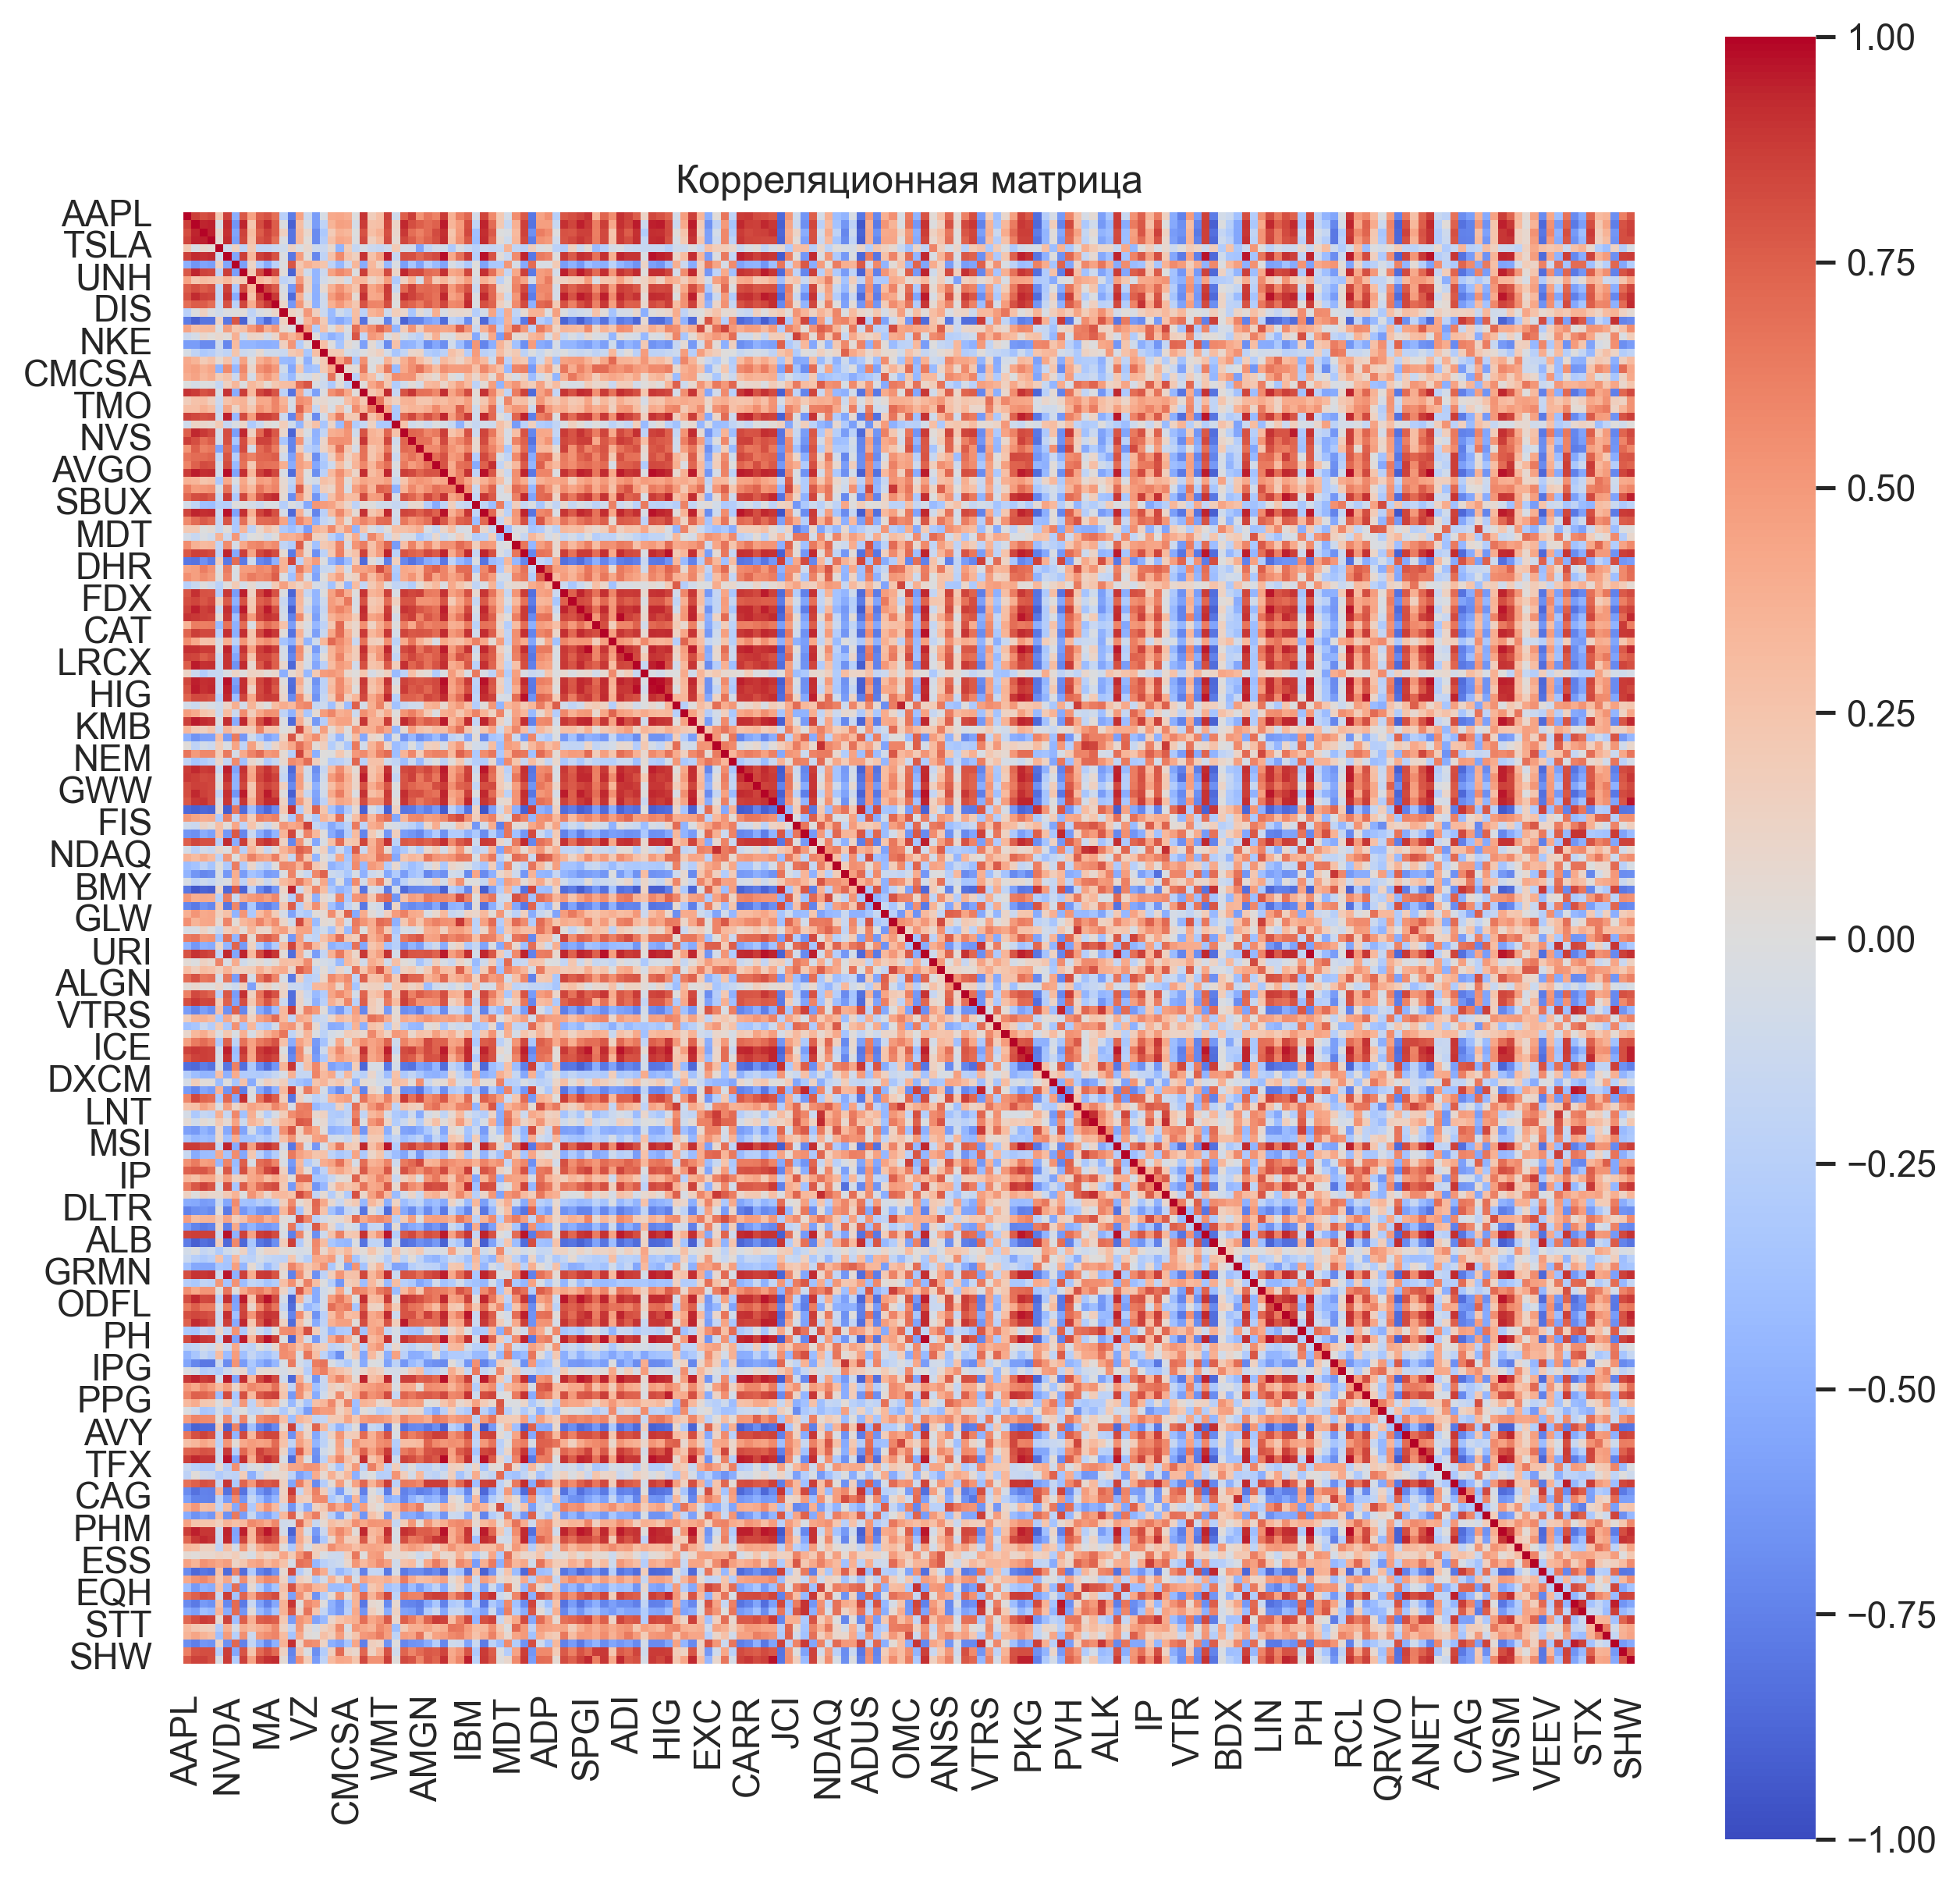

In [13]:
plt.figure(figsize=(10,10), dpi = 300)
sns.set(font_scale=1.0)

# Создаем тепловую карту
ax = sns.heatmap(
    corrMat,
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    square=True
)
ax.set_title("Корреляционная матрица")

# Показываем график
#plt.show()

plt.savefig('CorrMat_Pearson.png', dpi = 300)

In [14]:
for i in prange(n_stocks):
    for j in prange(n_stocks):
        corrMat.values[i][j] = mat[i][j]

In [15]:
mat

array([[ 1.        ,  0.30442754,  0.23343883, ...,  0.02868807,
         0.06235674,  0.34893599],
       [ 0.30442754,  1.        ,  0.6115313 , ...,  0.06906997,
         0.33656355,  0.01927529],
       [ 0.23343883,  0.6115313 ,  1.        , ...,  0.01198   ,
         0.48208212,  0.14140637],
       ...,
       [ 0.02868807,  0.06906997,  0.01198   , ...,  1.        ,
        -0.08018333, -0.09737791],
       [ 0.06235674,  0.33656355,  0.48208212, ..., -0.08018333,
         1.        ,  0.03577213],
       [ 0.34893599,  0.01927529,  0.14140637, ..., -0.09737791,
         0.03577213,  1.        ]])

In [16]:
corrMat

,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,JNJ,V,UNH,PG,...,EVRG,EQH,NWL,PGRE,STX,STT,TPR,SEE,FANG,SHW
AAPL,1.000000,0.304428,0.233439,0.372220,0.569108,0.559939,0.196430,-0.134167,0.549103,0.503870,...,0.545933,0.525085,-0.244206,0.412775,0.655995,0.513834,-0.058051,0.028688,0.062357,0.348936
MSFT,0.304428,1.000000,0.611531,0.519377,0.146402,0.498531,-0.259158,0.041066,-0.054057,0.309808,...,0.078144,0.408867,-0.458349,0.040504,0.443567,0.056396,0.179716,0.069070,0.336564,0.019275
AMZN,0.233439,0.611531,1.000000,0.486482,0.090200,0.522950,-0.258424,0.139877,-0.025255,0.401412,...,0.183815,0.519104,-0.381309,0.049232,0.437857,0.158071,0.262206,0.011980,0.482082,0.141406
GOOGL,0.372220,0.519377,0.486482,1.000000,0.150124,0.525411,-0.360062,-0.206490,0.057929,0.354381,...,0.215081,0.580365,-0.332932,0.138293,0.417210,0.129517,-0.102054,0.119104,0.428736,-0.061281
TSLA,0.569108,0.146402,0.090200,0.150124,1.000000,0.261185,0.295829,-0.141110,0.478445,0.229428,...,0.400040,0.266099,-0.128536,0.453857,0.409200,0.469571,-0.025771,0.000748,-0.097697,0.299312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STT,0.513834,0.056396,0.158071,0.129517,0.469571,0.357100,0.397421,0.041538,0.617880,0.430122,...,0.678680,0.468218,-0.014814,0.532242,0.469448,1.000000,0.053319,-0.008166,0.047870,0.630478
TPR,-0.058051,0.179716,0.262206,-0.102054,-0.025771,0.139163,0.067448,0.451491,-0.067314,0.130887,...,-0.025212,0.071913,-0.089210,-0.115614,0.159339,0.053319,1.000000,0.135857,0.096392,0.231829
SEE,0.028688,0.069070,0.011980,0.119104,0.000748,0.032745,-0.032306,0.041294,-0.010713,0.021543,...,-0.018862,0.091973,0.221157,0.075892,0.084304,-0.008166,0.135857,1.000000,-0.080183,-0.097378
FANG,0.062357,0.336564,0.482082,0.428736,-0.097697,0.379035,-0.338699,-0.070671,-0.091990,0.252929,...,0.105205,0.412907,-0.342511,-0.016766,0.207507,0.047870,0.096392,-0.080183,1.000000,0.035772


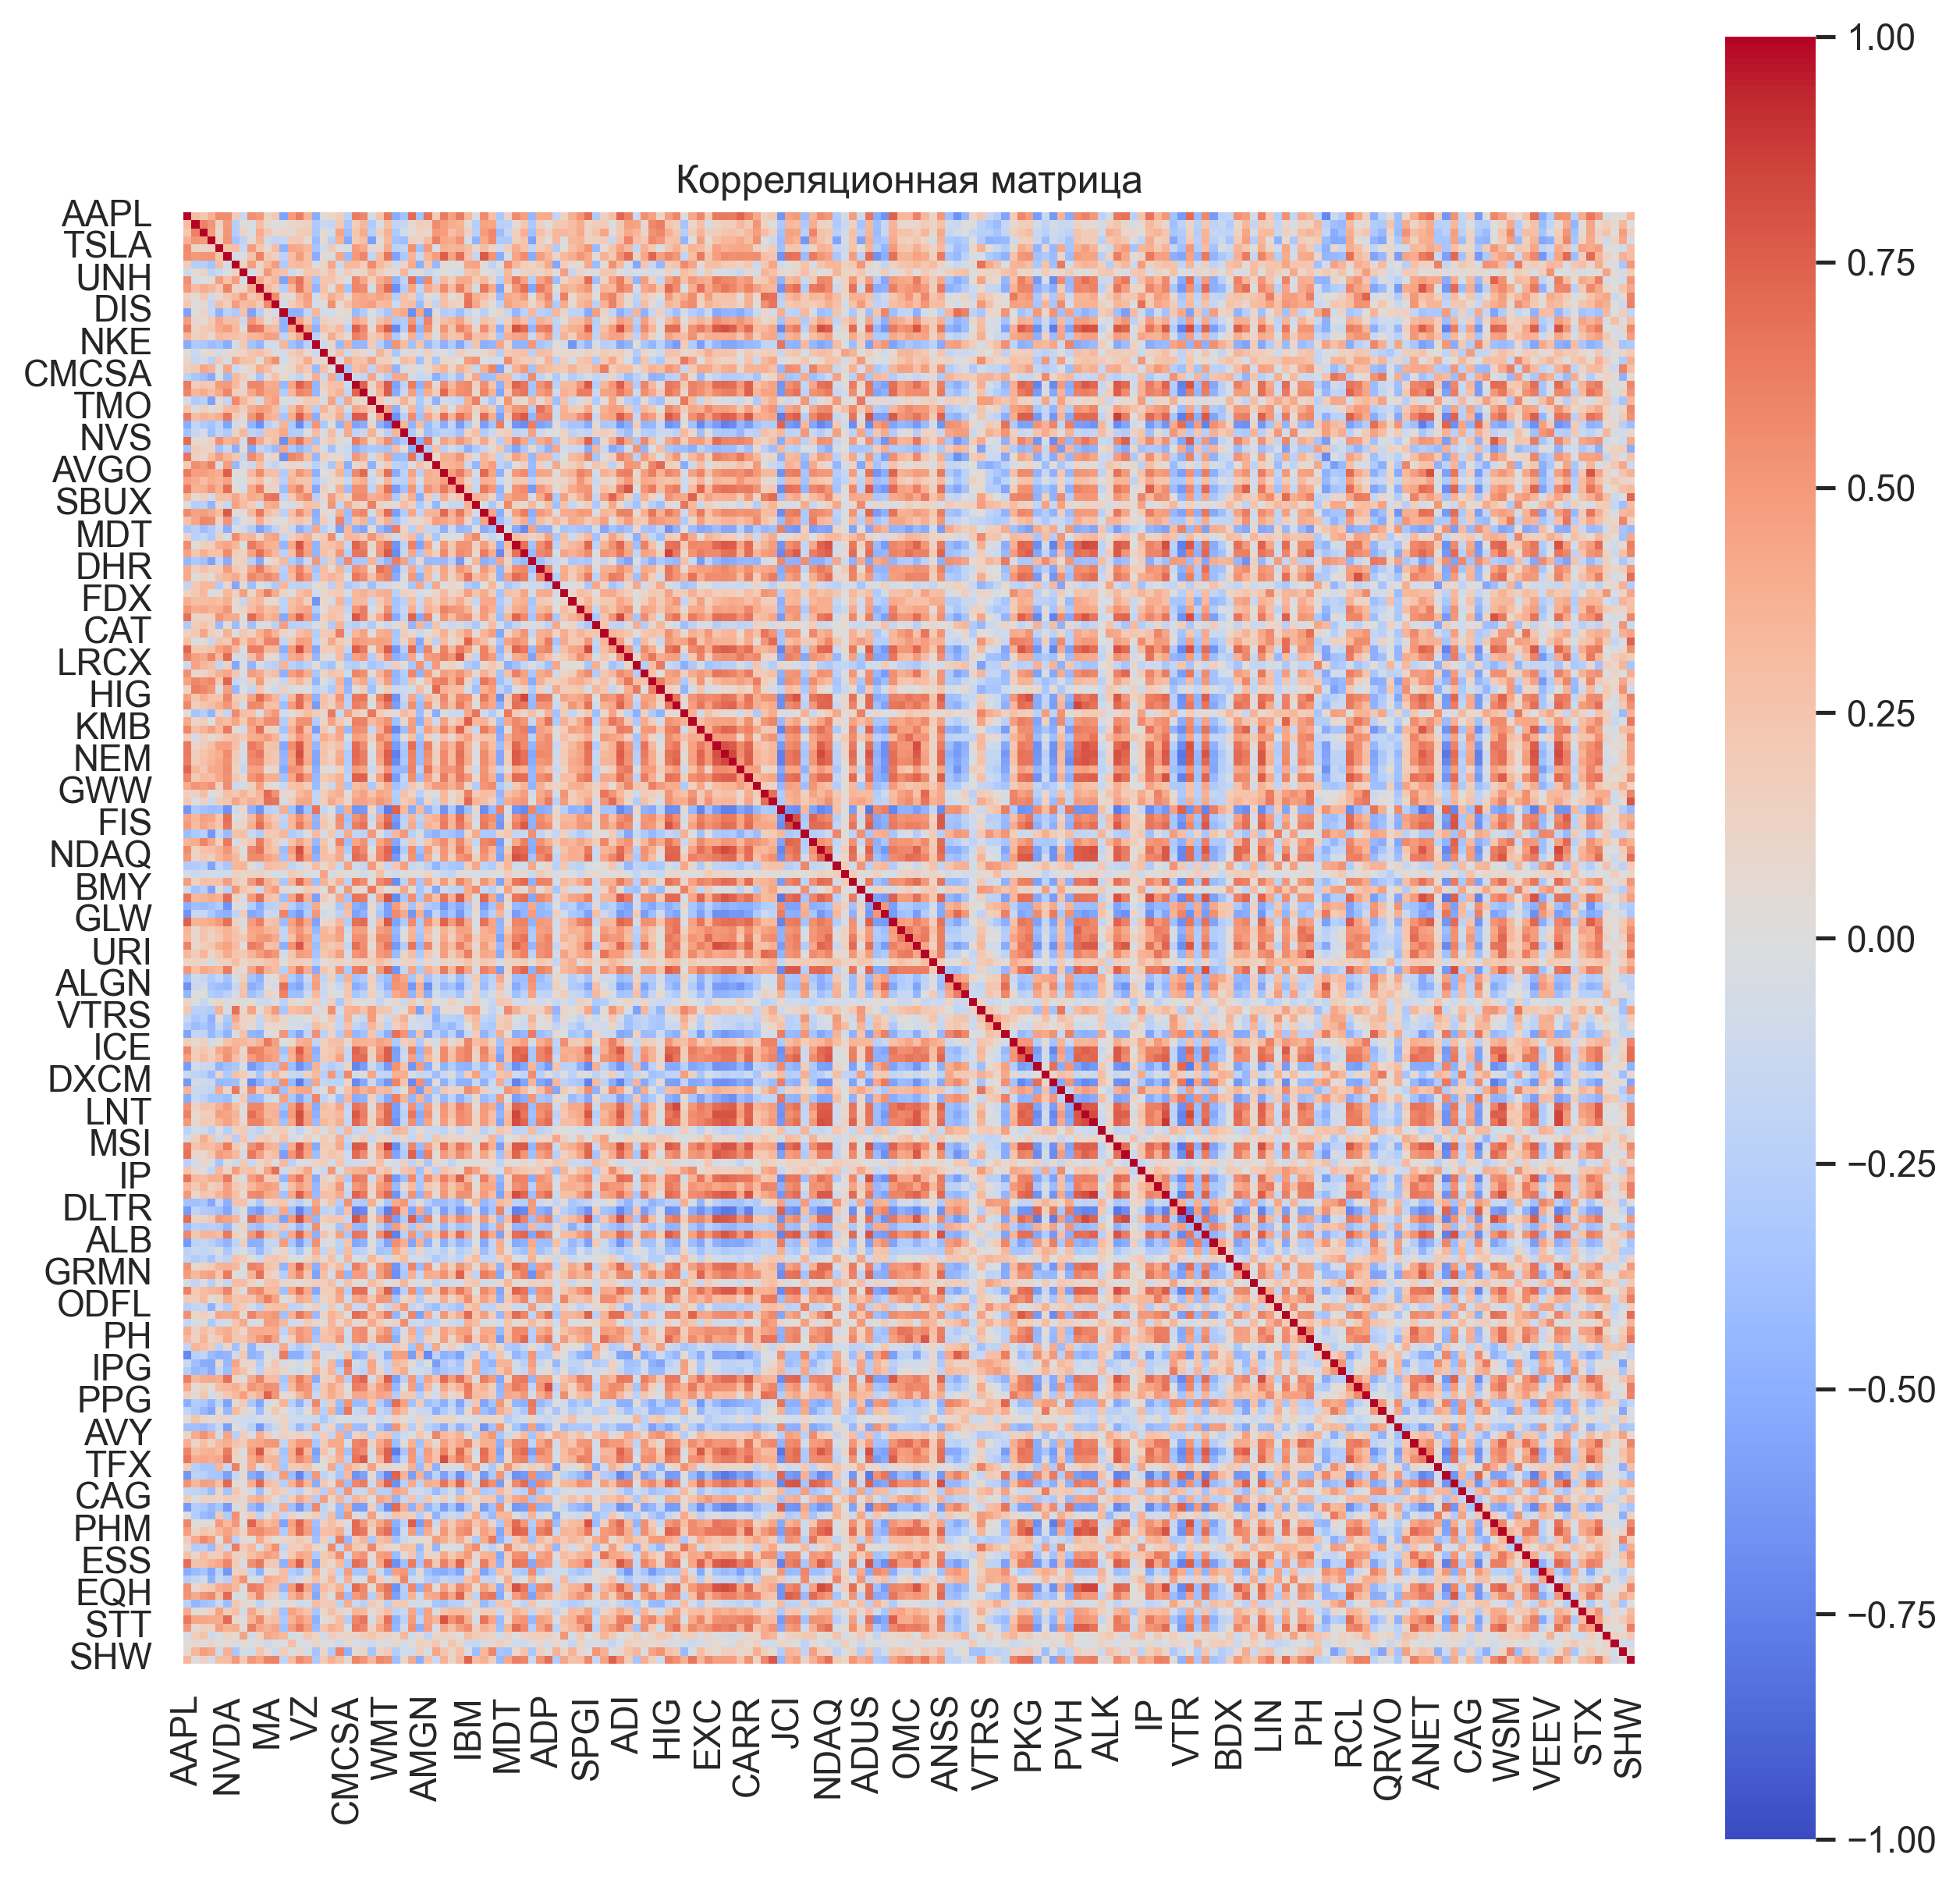

In [17]:
plt.figure(figsize=(10,10), dpi = 300)
sns.set(font_scale=1.0)

# Создаем тепловую карту
ax = sns.heatmap(
    corrMat,
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    square=True
)
ax.set_title("Корреляционная матрица")

# Показываем график
#plt.show()

plt.savefig('CorrMat_Sign.png', dpi = 300)